In [10]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, ConfusionMatrixDisplay
import datetime
import matplotlib.pyplot as plt

In [2]:
train_dir = 'data/saliency/train'
val_dir = 'data/saliency/validation'
test_dir = 'data/saliency/testing'

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode='binary'
)

# Generator untuk validasi
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    class_mode='binary'
)

# Generator untuk testing
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 22046 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'saliency_parasitized': 0, 'saliency_uninfected': 1}

In [5]:
# Load the base model MobileNetV3Large
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Create the model using Sequential
mobilenetv3_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),  # Stabilize training
    Dropout(0.1),  # Increase dropout
    Dense(256, activation='relu'),
    BatchNormalization(),  # Stabilize training
    Dropout(0.1),
    Dense(1, activation='sigmoid')   # Output layer
])

# Compile the model with a learning rate of 0.01
mobilenetv3_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [6]:


# Update the filepath to use the .keras extension
model_checkpoint_mobilenetv3 = ModelCheckpoint(
    filepath='saliency/best_mobilenetv3_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=2
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Hentikan jika tidak ada perbaikan setelah 10 epoch
    restore_best_weights=True,
    verbose=2
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi learning rate menjadi setengah
    patience=5,  # Setelah 5 epoch tanpa perbaikan
    min_lr=1e-7,  # Batas minimum learning rate
    verbose=2
)

# Tambahkan ke daftar callback
callbacks_mobilenetv3 = [model_checkpoint_mobilenetv3, early_stopping, reduce_lr]

In [7]:
history_mobilenetv3 = mobilenetv3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks_mobilenetv3
)


Epoch 1/50
345/345 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6537
Epoch 1: val_loss improved from inf to 0.65675, saving model to saliency\best_mobilenetv3_model.h5


C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


345/345 [==============================] - 220s 632ms/step - loss: 0.6415 - accuracy: 0.6537 - val_loss: 0.6567 - val_accuracy: 0.5733 - lr: 1.0000e-04
Epoch 2/50
345/345 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.6825
Epoch 2: val_loss improved from 0.65675 to 0.46892, saving model to saliency\best_mobilenetv3_model.h5
345/345 [==============================] - 219s 635ms/step - loss: 0.5965 - accuracy: 0.6825 - val_loss: 0.4689 - val_accuracy: 0.7770 - lr: 1.0000e-04
Epoch 3/50
345/345 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.6986
Epoch 3: val_loss did not improve from 0.46892
345/345 [==============================] - 221s 641ms/step - loss: 0.5761 - accuracy: 0.6986 - val_loss: 0.4940 - val_accuracy: 0.7494 - lr: 1.0000e-04
Epoch 4/50
345/345 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7010
Epoch 4: val_loss did not improve from 0.46892
345/345 [==============================] - 219s 635ms/step 

In [8]:
# Paths for saving results and plots
output_csv_path_mobilenet = 'saliency/mobilenet_saliency_test_results.csv'
roc_curve_path_mobilenet = 'saliency/mobilenet_saliency_roc_curve.png'

# Get true labels and predictions
y_true = test_generator.classes
y_pred_prob = mobilenetv3_model.predict(test_generator)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Get filenames
filenames = test_generator.filenames

# Create DataFrame for results
results_df = pd.DataFrame({
    'Nama File': filenames,
    'Label Asli': y_true,
    'Prediksi': y_pred.flatten()
})

# Calculate Metrics
mcc_mobilenet = matthews_corrcoef(y_true, y_pred)
auc_roc_mobilenet = roc_auc_score(y_true, y_pred_prob)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print Metrics
print(f"MobilenetV3 Metrics:\n"
      f"MCC: {mcc_mobilenet}\n"
      f"AUC-ROC: {auc_roc_mobilenet}\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1-Score: {f1}")

# Append metrics to DataFrame for the entire dataset
results_df['MCC'] = [mcc_mobilenet] * len(results_df)
results_df['AUC-ROC'] = [auc_roc_mobilenet] * len(results_df)
results_df['Accuracy'] = [accuracy] * len(results_df)
results_df['Precision'] = [precision] * len(results_df)
results_df['Recall'] = [recall] * len(results_df)
results_df['F1-Score'] = [f1] * len(results_df)

# Save the results to CSV
results_df.to_csv(output_csv_path_mobilenet, index=False)
print(f"Hasil prediksi MobilenetV3 disimpan di {output_csv_path_mobilenet}")

# Plot and save ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)  # Use probabilities directly
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig(roc_curve_path_mobilenet)
plt.close()


22/22 [==============================] - 11s 464ms/step
MobilenetV3 Metrics:
MCC: 0.602392625827354
AUC-ROC: 0.8981654487583233
Accuracy: 0.7982583454281568
Precision: 0.7617834394904459
Recall: 0.8679245283018868
F1-Score: 0.8113975576662144
Hasil prediksi MobilenetV3 disimpan di saliency/mobilenet_saliency_test_results.csv


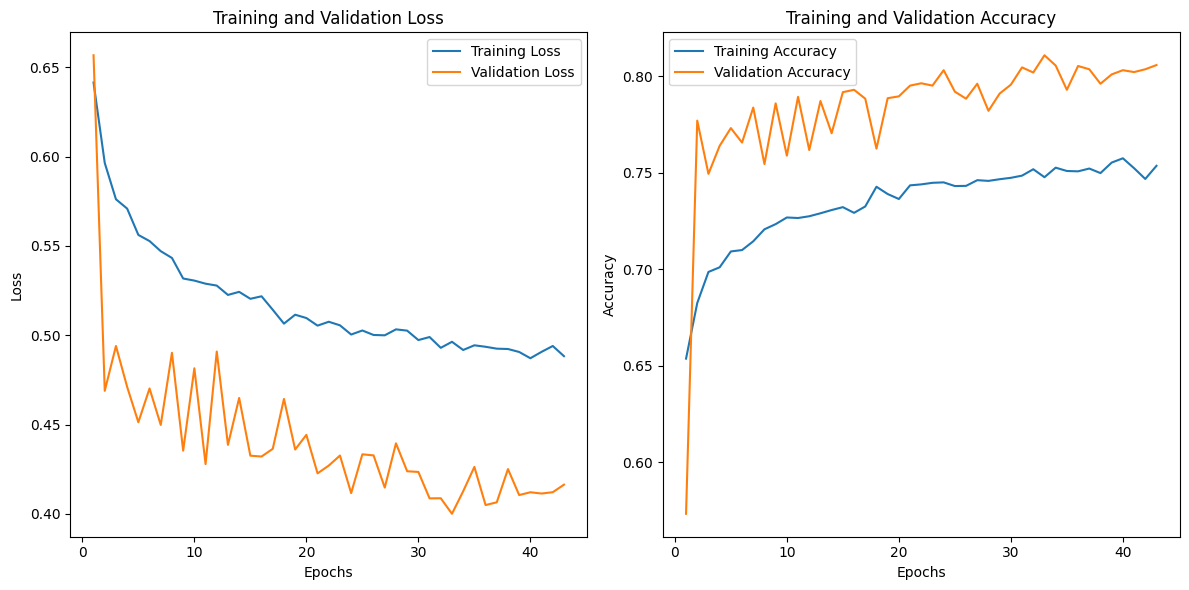

In [9]:
import matplotlib.pyplot as plt

# Ambil data dari history
history = history_mobilenetv3.history
epochs = range(1, len(history['loss']) + 1)

# Buat plot
plt.figure(figsize=(12, 6))

# Plot Loss dan Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy dan Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Simpan plot
plt.tight_layout()
plt.savefig('training_validation_metrics.png', dpi=300)  # Simpan gambar dengan nama file dan resolusi
plt.show()


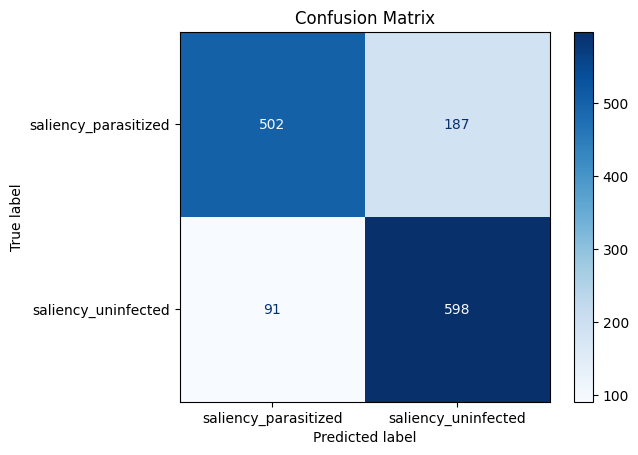

In [14]:
cm = confusion_matrix(y_true, y_pred)

class_label = list(test_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()